In [1]:
import os, sys
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader

# Para que el notebook vea la raíz del proyecto
ROOT_DIR = os.path.abspath(os.path.join(os.getcwd(), ".."))
if ROOT_DIR not in sys.path:
    sys.path.append(ROOT_DIR)

print("ROOT_DIR:", ROOT_DIR)
print("PyTorch:", torch.__version__)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Device:", device)


ROOT_DIR: c:\Users\walte\Documents\ProyectoCom2
PyTorch: 2.9.1+cpu
Device: cpu


In [2]:
dataset_path = os.path.join(ROOT_DIR, "data", "iq_dataset.npz")
data = np.load(dataset_path)

print("Claves en el archivo:", data.files)

X_train = data["X_train"]   # (N_train, 2, Nsym)
y_train = data["y_train"]   # (N_train,)
X_val   = data["X_val"]
y_val   = data["y_val"]
mods    = data["modulations"]   # array de strings con nombres de clases

print("X_train:", X_train.shape)
print("y_train:", y_train.shape)
print("X_val  :", X_val.shape)
print("y_val  :", y_val.shape)
print("Clases:", mods)
num_classes = len(mods)


Claves en el archivo: ['X_train', 'y_train', 'snr_train', 'X_val', 'y_val', 'snr_val', 'modulations']
X_train: (7200, 4, 256)
y_train: (7200,)
X_val  : (1800, 4, 256)
y_val  : (1800,)
Clases: ['ASK2' 'ASK4' 'BPSK' 'QPSK' 'PSK8' 'QAM16' 'QAM32' 'FSK2' 'FSK4']


In [3]:
class IQModDataset(Dataset):
    def __init__(self, X, y):
        # X: numpy (N, 2, Nsym)
        # y: numpy (N,)
        self.X = torch.from_numpy(X).float()
        self.y = torch.from_numpy(y).long()

    def __len__(self):
        return self.X.shape[0]

    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

batch_size = 64

train_dataset = IQModDataset(X_train, y_train)
val_dataset   = IQModDataset(X_val, y_val)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader   = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

len(train_dataset), len(val_dataset)


(7200, 1800)

In [4]:
class IQCNN(nn.Module):
    def __init__(self, num_classes):
        super(IQCNN, self).__init__()
        self.features = nn.Sequential(
            nn.Conv1d(4, 16, kernel_size=5, padding=2),
            nn.ReLU(),
            nn.MaxPool1d(2),      # 256 -> 128
            nn.Conv1d(16, 32, kernel_size=5, padding=2),
            nn.ReLU(),
            nn.MaxPool1d(2),      # 128 -> 64
            nn.Conv1d(32, 64, kernel_size=5, padding=2),
            nn.ReLU(),
            nn.MaxPool1d(2),      # 64 -> 32
        )
        self.classifier = nn.Sequential(
            nn.Flatten(),         # 64 * 32 features
            nn.Linear(64 * 32, 128),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(128, num_classes)
        )

    def forward(self, x):
        x = self.features(x)
        x = self.classifier(x)
        return x

model = IQCNN(num_classes).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-3)

print(model)


IQCNN(
  (features): Sequential(
    (0): Conv1d(4, 16, kernel_size=(5,), stride=(1,), padding=(2,))
    (1): ReLU()
    (2): MaxPool1d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv1d(16, 32, kernel_size=(5,), stride=(1,), padding=(2,))
    (4): ReLU()
    (5): MaxPool1d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv1d(32, 64, kernel_size=(5,), stride=(1,), padding=(2,))
    (7): ReLU()
    (8): MaxPool1d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (classifier): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=2048, out_features=128, bias=True)
    (2): ReLU()
    (3): Dropout(p=0.3, inplace=False)
    (4): Linear(in_features=128, out_features=9, bias=True)
  )
)


In [5]:
def train_one_epoch(model, loader, optimizer, criterion, device):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0

    for X_batch, y_batch in loader:
        X_batch = X_batch.to(device)
        y_batch = y_batch.to(device)

        optimizer.zero_grad()
        outputs = model(X_batch)
        loss = criterion(outputs, y_batch)
        loss.backward()
        optimizer.step()

        running_loss += loss.item() * X_batch.size(0)
        _, preds = torch.max(outputs, 1)
        total += y_batch.size(0)
        correct += (preds == y_batch).sum().item()

    epoch_loss = running_loss / total
    epoch_acc = correct / total
    return epoch_loss, epoch_acc


def evaluate(model, loader, criterion, device):
    model.eval()
    running_loss = 0.0
    correct = 0
    total = 0

    with torch.no_grad():
        for X_batch, y_batch in loader:
            X_batch = X_batch.to(device)
            y_batch = y_batch.to(device)

            outputs = model(X_batch)
            loss = criterion(outputs, y_batch)

            running_loss += loss.item() * X_batch.size(0)
            _, preds = torch.max(outputs, 1)
            total += y_batch.size(0)
            correct += (preds == y_batch).sum().item()

    epoch_loss = running_loss / total
    epoch_acc = correct / total
    return epoch_loss, epoch_acc


In [145]:
num_epochs = 50   # puedes subir/bajar esto
best_val_acc = 0.0
model_path = os.path.join(ROOT_DIR, "data", "iq_cnn_model.pth")

for epoch in range(1, num_epochs + 1):
    train_loss, train_acc = train_one_epoch(model, train_loader, optimizer, criterion, device)
    val_loss, val_acc = evaluate(model, val_loader, criterion, device)

    print(f"Epoch {epoch:02d}: "
          f"Train Loss={train_loss:.4f}, Train Acc={train_acc*100:.2f}% | "
          f"Val Loss={val_loss:.4f}, Val Acc={val_acc*100:.2f}%")

    # Guardar el mejor modelo
    if val_acc > best_val_acc:
        best_val_acc = val_acc
        torch.save({
            "model_state_dict": model.state_dict(),
            "classes": mods,
        }, model_path)
        print(f"  -> Modelo mejorado, guardado en {model_path}")

print(f"Mejor exactitud en validación: {best_val_acc*100:.2f}%")


Epoch 01: Train Loss=0.0104, Train Acc=99.69% | Val Loss=1.2418, Val Acc=81.00%
  -> Modelo mejorado, guardado en c:\Users\walte\Documents\ProyectoCom2\data\iq_cnn_model.pth
Epoch 02: Train Loss=0.0069, Train Acc=99.75% | Val Loss=1.2948, Val Acc=81.00%
Epoch 03: Train Loss=0.0043, Train Acc=99.92% | Val Loss=1.4240, Val Acc=80.94%
Epoch 04: Train Loss=0.0179, Train Acc=99.43% | Val Loss=1.6208, Val Acc=78.83%
Epoch 05: Train Loss=0.0145, Train Acc=99.40% | Val Loss=1.3237, Val Acc=81.06%
  -> Modelo mejorado, guardado en c:\Users\walte\Documents\ProyectoCom2\data\iq_cnn_model.pth
Epoch 06: Train Loss=0.0102, Train Acc=99.56% | Val Loss=1.4411, Val Acc=80.78%
Epoch 07: Train Loss=0.0167, Train Acc=99.42% | Val Loss=1.5468, Val Acc=79.56%
Epoch 08: Train Loss=0.0274, Train Acc=99.18% | Val Loss=1.2697, Val Acc=80.17%
Epoch 09: Train Loss=0.0063, Train Acc=99.81% | Val Loss=1.3800, Val Acc=79.89%
Epoch 10: Train Loss=0.0054, Train Acc=99.79% | Val Loss=1.4480, Val Acc=81.28%
  -> Modelo 

In [146]:
import numpy as np
import torch

# Usamos el modelo entrenado "model" y el val_loader que ya definiste arriba
model.eval()

all_preds = []
all_labels = []

with torch.no_grad():
    for X_batch, y_batch in val_loader:
        X_batch = X_batch.to(device)
        y_batch = y_batch.to(device)

        outputs = model(X_batch)
        _, preds = torch.max(outputs, 1)

        all_preds.append(preds.cpu().numpy())
        all_labels.append(y_batch.cpu().numpy())

all_preds = np.concatenate(all_preds)
all_labels = np.concatenate(all_labels)

acc = (all_preds == all_labels).mean()
print(f"Accuracy total en validación: {acc*100:.2f}%")


Accuracy total en validación: 80.61%


In [147]:
## Necesitas haber cargado también snr_val del .npz
snr_val = data["snr_val"]

snr_unique = np.unique(snr_val)
for snr in snr_unique:
    mask = (snr_val == snr)
    acc_snr = (all_preds[mask] == all_labels[mask]).mean()
    print(f"SNR = {snr:2d} dB -> Acc = {acc_snr*100:5.2f}%  (N={mask.sum()})")


SNR =  0 dB -> Acc = 67.41%  (N=580)
SNR =  5 dB -> Acc = 83.50%  (N=612)
SNR = 10 dB -> Acc = 87.32%  (N=205)
SNR = 15 dB -> Acc = 92.52%  (N=214)
SNR = 20 dB -> Acc = 91.01%  (N=189)


In [148]:
checkpoint = torch.load(model_path, map_location=device, weights_only=False)

model_loaded = IQCNN(num_classes)
model_loaded.load_state_dict(checkpoint["model_state_dict"])
model_loaded.to(device)
model_loaded.eval()

# Convertir a strings normales de Python
raw_classes = checkpoint["classes"]      # esto es un np.array de np.str_
class_names = [str(c) for c in raw_classes]

print("Clases:", class_names)



Clases: ['ASK2', 'ASK4', 'BPSK', 'QPSK', 'PSK8', 'QAM16', 'QAM32', 'FSK2', 'FSK4']


Matriz de confusión:
 [[211   0   0   0   0   0   0   0   0]
 [  0 161  25   0   0   0   0   0   0]
 [  0  20 172   1   0   0   0   0   0]
 [  0   0   3  98  69  19   2   0   1]
 [  0   1   0  68  99  37   2   0   0]
 [  0   0   0  17  47 137   3   0   0]
 [  0   0   0   0   1   0 202   0   0]
 [  0   0   0   0   0   0   0 191  14]
 [  0   0   0   0   0   0   0  19 180]]


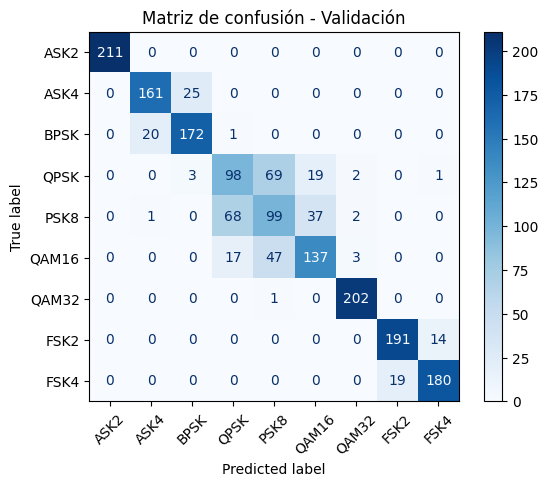

In [149]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
import numpy as np

# Asegúrate de tener all_labels y all_preds de la celda anterior.
cm = confusion_matrix(all_labels, all_preds, labels=range(num_classes))
print("Matriz de confusión:\n", cm)

disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)
disp.plot(cmap="Blues", xticks_rotation=45)
plt.title("Matriz de confusión - Validación")
plt.show()


In [150]:
import numpy as np
import matplotlib.pyplot as plt
from numpy.fft import fft, fftshift, fftfreq
import torch

def parse_modulation_name(name: str):
    """
    Separa tipo y orden para nombres como:
    'ASK2', 'ASK4', 'BPSK', 'QPSK', 'PSK8', 'QAM16', 'QAM32', etc.
    """
    n = str(name).upper()

    # Casos especiales comunes
    if n == "BPSK":
        return "PSK", 2
    if n == "QPSK":
        return "PSK", 4

    # PSK genérico: 'PSK8', 'PSK16', etc.
    if n.startswith("PSK"):
        suf = n[3:]
        try:
            order = int(suf)
        except ValueError:
            order = None
        return "PSK", order

    # ASK / FSK / QAM típicos: 'ASK2', 'ASK4', 'QAM16', 'QAM32', ...
    for t in ["ASK", "FSK", "QAM"]:
        if n.startswith(t):
            suf = n[len(t):]
            try:
                order = int(suf)
            except ValueError:
                order = None
            return t, order

    # Si no matchea nada:
    return "DESCONOCIDO", None


def describe_modulation(name: str) -> str:
    tipo, orden = parse_modulation_name(name)
    base = f"Modulación {tipo}"
    if orden is not None:
        base += f" de orden M={orden}"
    base += "."

    if tipo == "ASK":
        extra = (
            " La información se transmite variando niveles de amplitud en la parte real. "
            "Para M>2 hay varios niveles discretos; para M=2 (ASK2 unipolar) hay un nivel apagado/encendido."
        )
    elif tipo == "PSK":
        extra = (
            " La amplitud es aproximadamente constante y la información se codifica en la fase. "
            "A mayor orden M, hay más puntos equiespaciados en el círculo unitario."
        )
    elif tipo == "QAM":
        extra = (
            " La información se codifica tanto en amplitud como en fase. "
            "La constelación típica es una rejilla rectangular en el plano I/Q."
        )
    elif tipo == "FSK":
        extra = (
            " La información se representa mediante diferentes frecuencias portadoras."
        )
    else:
        extra = " Tipo de modulación no reconocido en el esquema actual."

    return base + extra


def classify_and_describe_signal(model,
                                 iq_input,
                                 class_names,
                                 fs_sym: float | None = None,
                                 title_prefix: str = ""):
    """
    iq_input: puede ser
        - array complejo de shape (Nsym,), o
        - array real de shape (2, Nsym) con [I; Q]
    fs_sym: frecuencia de muestreo por símbolo (solo para eje de tiempo/frecuencia), opcional.
    """

    # 1) Normalizar entrada a shape (1, 2, Nsym)
    iq_input = np.asarray(iq_input)

    if np.iscomplexobj(iq_input):
        # Caso: señal compleja s[n] (como la que sale de generate_baseband)
        I = np.real(iq_input)
        Q = np.imag(iq_input)
        mag = np.abs(iq_input)
        phase = np.angle(iq_input)
        iq = np.stack([I, Q, mag, phase], axis=0)   # (4, Nsym)
    else:
        # Caso: ya viene en forma de tensor con canales (por ej. salida del DataLoader)
        # Aquí asumimos que iq_input ya es (4, Nsym) porque el dataset tiene 4 canales
        if iq_input.ndim == 1:
            raise ValueError("Si no es complejo, iq_input debe ser shape (C, Nsym).")
        iq = iq_input

    iq = iq.astype(np.float32)
    Nsym = iq.shape[1]

    X_tensor = torch.from_numpy(iq).unsqueeze(0).to(device)  # (1, 2, Nsym)

    # 2) Pasar por la red
    model.eval()
    with torch.no_grad():
        outputs = model(X_tensor)
        probs = torch.softmax(outputs, dim=1)
        conf, pred_idx = torch.max(probs, dim=1)

    pred_idx = pred_idx.item()
    conf = conf.item()
    pred_name = class_names[pred_idx]
    tipo, orden = parse_modulation_name(pred_name)
    desc = describe_modulation(pred_name)

    print("======================================")
    print("RESULTADO DEL CLASIFICADOR")
    print(f"Predicción: {pred_name}")
    print(f"  -> Tipo   : {tipo}")
    print(f"  -> Orden  : {orden}")
    print(f"  -> Confianza: {conf*100:.2f}%\n")
    print("Descripción breve:")
    print(desc)
    print("======================================")

    # 3) Graficar características
    I = iq[0]
    Q = iq[1]

    # 3.1 Forma de onda (parte real)
    plt.figure(figsize=(8, 2))
    if fs_sym is not None:
        t = np.arange(Nsym) / fs_sym
        plt.plot(t, I, marker='o', linewidth=0.8)
        plt.xlabel("Tiempo (s)")
    else:
        plt.plot(I, marker='o', linewidth=0.8)
        plt.xlabel("n (símbolo)")
    plt.title(f"{title_prefix}Forma de onda (parte real) - pred: {pred_name}")
    plt.grid(True)
    plt.tight_layout()
    plt.show()

    # 3.2 Diagrama de constelación
    plt.figure(figsize=(4, 4))
    plt.scatter(I, Q, s=8)
    plt.axhline(0, color='k', linewidth=0.3)
    plt.axvline(0, color='k', linewidth=0.3)
    plt.xlabel("I")
    plt.ylabel("Q")
    plt.title(f"{title_prefix}Constelación - pred: {pred_name}")
    plt.grid(True, alpha=0.4)
    plt.gca().set_aspect('equal', 'box')
    plt.tight_layout()
    plt.show()

    # 3.3 Espectro (FFT de I + jQ)
    s_complex = I + 1j * Q
    S = fftshift(fft(s_complex))
    N = len(S)
    S_mag = 20 * np.log10(np.abs(S) + 1e-12)

    if fs_sym is not None:
        freqs = fftshift(fftfreq(N, d=1/fs_sym))
        x_label = "Frecuencia (Hz)"
    else:
        freqs = fftshift(fftfreq(N, d=1.0))
        x_label = "Frecuencia normalizada"

    plt.figure(figsize=(8, 3))
    plt.plot(freqs, S_mag, linewidth=0.8)
    plt.title(f"{title_prefix}Espectro |S(f)| en dB - pred: {pred_name}")
    plt.xlabel(x_label)
    plt.ylabel("Magnitud (dB)")
    plt.grid(True, alpha=0.4)
    plt.tight_layout()
    plt.show()


RESULTADO DEL CLASIFICADOR
Predicción: PSK8
  -> Tipo   : PSK
  -> Orden  : 8
  -> Confianza: 81.88%

Descripción breve:
Modulación PSK de orden M=8. La amplitud es aproximadamente constante y la información se codifica en la fase. A mayor orden M, hay más puntos equiespaciados en el círculo unitario.


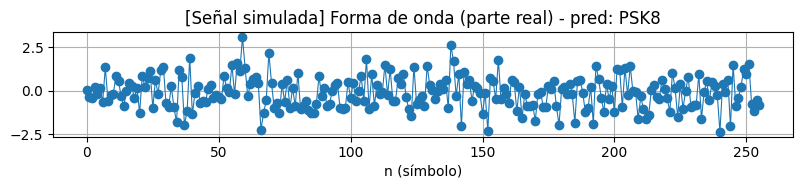

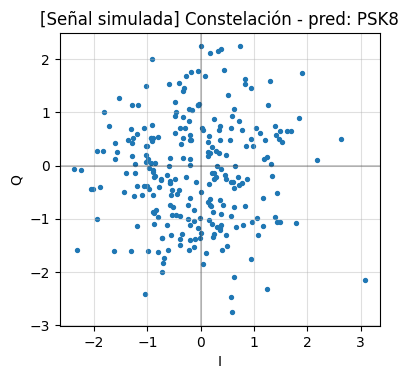

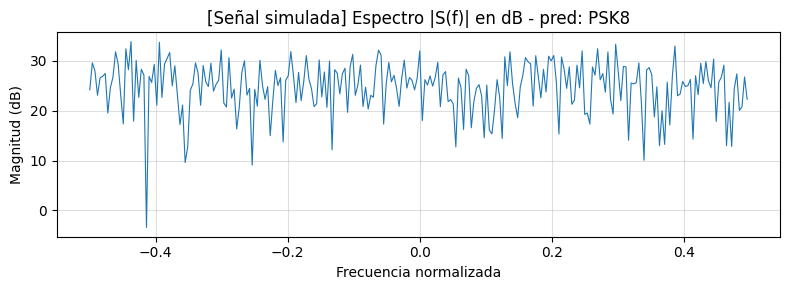

In [151]:
from src.generate_signals import generate_baseband

# Generamos una señal modulada nueva (no viene del dataset .npz)
out = generate_baseband("QPSK", Nsym=256, snr_db=0)  # puedes cambiar QAM16, SNR, etc.
s = out["s_noisy"]   # señal compleja, shape (256,)

# Le pedimos al clasificador que:
# - reconozca la modulación
# - diga el orden
# - muestre forma de onda, constelación y espectro
classify_and_describe_signal(
    model,
    s,
    class_names,
    fs_sym=None,
    title_prefix="[Señal simulada] "
)
